In [33]:
import numpy as np
import os
from typing import Tuple
import tensorflow as tf
from sklearn.utils import class_weight

# LSTM Classification

In [114]:
NUMBER_OF_CLASSES = 6
EPOCHS = 50

TRAINING_PATH = "../data_collection/datasets/training"
TEST_PATH = "../data_collection/datasets/test"

x_training = np.load(os.path.join(TRAINING_PATH, "class", "features.npy"), allow_pickle=True)
x_training = np.array([x_training[i].T for i in range(x_training.shape[0])])[-900:]
y_training = np.load(os.path.join(TRAINING_PATH, "class", "labels.npy"), allow_pickle=True)[-900:]

# Calculate class weights
class_weights = class_weight.compute_class_weight(class_weight='balanced', classes=np.unique(y_training), y=y_training)

# Convert class weights to a dictionary
class_weights_dict = dict(enumerate(class_weights))

INPUT_DIM = x_training.shape[1:]

x_training = tf.convert_to_tensor(x_training.astype('float32'))
y_training = tf.convert_to_tensor(y_training.astype('int32'))

# x_training = x_training.astype('float32')
# y_training = y_training.astype('int32')
# y_training = tf.one_hot(y_training, 5)



In [115]:
class_weights = tf.cast(tf.constant(class_weights), "float32")
class_weights

<tf.Tensor: shape=(6,), dtype=float32, numpy=
array([1.3392857 , 1.2931035 , 0.8196721 , 0.73170733, 1.1278195 ,
       0.9933775 ], dtype=float32)>

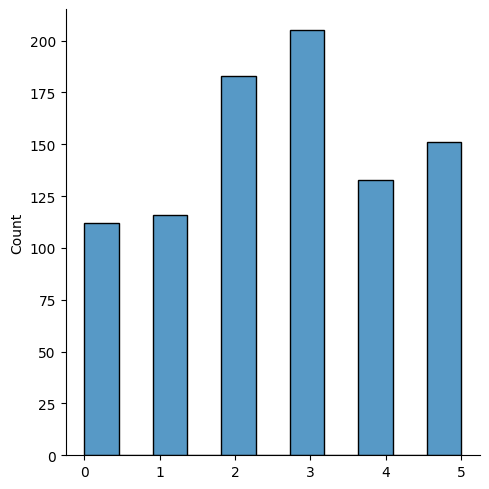

In [116]:
import seaborn as sns

sns.displot(y_training)

In [117]:
def weightedLoss(weights=tf.constant([1,1,1,1,1])):
    def innerLoss(true, pred):
        w = tf.gather(weights, true) #(batch, labels, 1)

        loss = tf.keras.backend.sparse_categorical_crossentropy(true, pred) #(batch, labels)
        loss = w * loss

        return loss

    return innerLoss

In [118]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
lr_scheduler_plt = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=0.005)
lr_scheduler_exp = tf.keras.optimizers.schedules.ExponentialDecay(0.005, 100, 0.9, staircase=True)

In [119]:
def create_lstm_model(input_shape:Tuple[int, int]) -> tf.keras.Model:
    
    model = tf.keras.Sequential([
        tf.keras.layers.InputLayer(input_shape=input_shape),
        tf.keras.layers.LSTM(128, activation="tanh", return_sequences=True),
        tf.keras.layers.LSTM(256, activation="tanh", return_sequences=True),
        tf.keras.layers.LSTM(512, activation="tanh", return_sequences=False),
        # tf.keras.layers.LSTM(128, activation="tanh"),
        # tf.keras.layers.Dense(128, activation="relu"),
        tf.keras.layers.Dense(64, activation="relu"),
        tf.keras.layers.Dense(NUMBER_OF_CLASSES, activation="softmax")
    ])

    model.compile(
        # loss=weightedLoss(class_weights),
        loss="sparse_categorical_crossentropy",
        optimizer=tf.keras.optimizers.legacy.Adam(learning_rate=0.005, epsilon=3e-03),
        metrics=["acc"]
    )

    return model

In [120]:
model = create_lstm_model(INPUT_DIM)

In [121]:

history = model.fit(x_training, 
                    y_training, 
                    validation_split=0.10,
                    epochs=EPOCHS, 
                    batch_size=36,
                    validation_batch_size=36,
                    # callbacks=[lr_scheduler]
                    )

Epoch 1/50
23/23 [==============================] - 4s 90ms/step - loss: 1.7840 - acc: 0.2185 - val_loss: 1.7576 - val_acc: 0.2556
Epoch 2/50
23/23 [==============================] - 1s 32ms/step - loss: 1.7891 - acc: 0.2025 - val_loss: 1.7601 - val_acc: 0.2444
Epoch 3/50
23/23 [==============================] - 1s 34ms/step - loss: 1.7988 - acc: 0.2099 - val_loss: 1.8451 - val_acc: 0.2444
Epoch 4/50
23/23 [==============================] - 1s 33ms/step - loss: 1.7869 - acc: 0.2272 - val_loss: 1.8014 - val_acc: 0.2444
Epoch 5/50
23/23 [==============================] - 1s 33ms/step - loss: 1.8062 - acc: 0.2062 - val_loss: 1.8228 - val_acc: 0.2222
Epoch 6/50
23/23 [==============================] - 1s 31ms/step - loss: 1.7964 - acc: 0.2111 - val_loss: 1.8577 - val_acc: 0.2333
Epoch 7/50
23/23 [==============================] - 1s 32ms/step - loss: 1.7550 - acc: 0.2506 - val_loss: 1.8077 - val_acc: 0.2222
Epoch 8/50
23/23 [==============================] - 1s 30ms/step - loss: 1.7277 - a

In [122]:
model.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_23 (LSTM)              (None, 23, 128)           84480     
                                                                 
 lstm_24 (LSTM)              (None, 23, 256)           394240    
                                                                 
 lstm_25 (LSTM)              (None, 512)               1574912   
                                                                 
 dense_11 (Dense)            (None, 64)                32832     
                                                                 
 dense_12 (Dense)            (None, 6)                 390       
                                                                 
Total params: 2,086,854
Trainable params: 2,086,854
Non-trainable params: 0
_________________________________________________________________


In [123]:
accuracy = history.history["acc"]
val_accuracy = history.history["val_acc"]

loss = history.history["loss"]
val_loss = history.history["val_loss"]

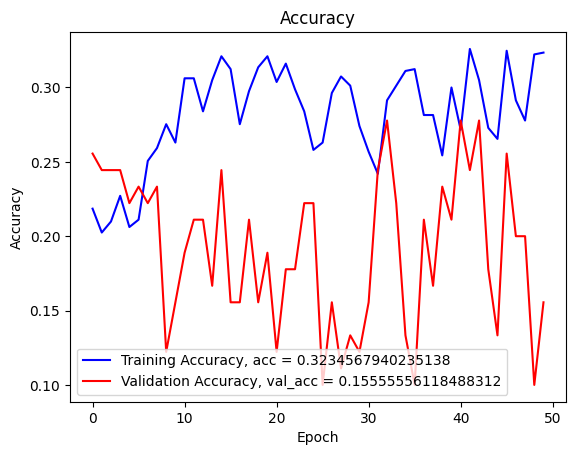

In [124]:
import matplotlib.pyplot as plt
plt.plot(range(len(accuracy)), accuracy, "b", label = f"Training Accuracy, acc = {accuracy[-1]}")
plt.plot(range(len(accuracy)), val_accuracy, "-r", label = f"Validation Accuracy, val_acc = {val_accuracy[-1]}")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.title("Accuracy")
plt.show()

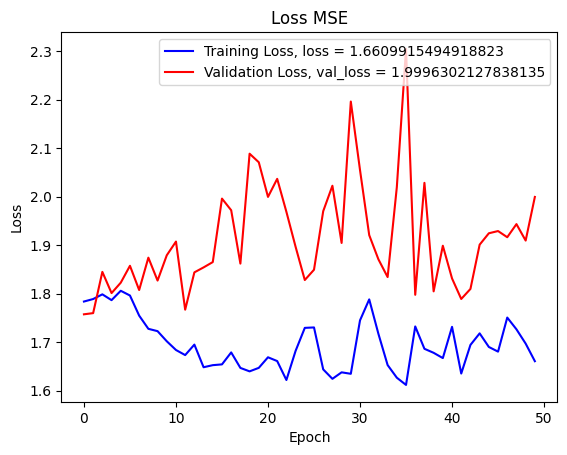

In [125]:
plt.plot(range(EPOCHS), loss, "b", label = f"Training Loss, loss = {loss[-1]}")
plt.plot(range(EPOCHS), val_loss, "-r", label = f"Validation Loss, val_loss = {val_loss[-1]}")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.title("Loss MSE")
plt.show()

In [132]:
x_test = np.load(os.path.join(TEST_PATH, "class", "features.npy"), allow_pickle=True)
x_test = np.array([x_test[i].T for i in range(x_test.shape[0])])
y_test = np.load(os.path.join(TEST_PATH, "class", "labels.npy"), allow_pickle=True)

INPUT_DIM = x_test.shape[1:]

x_test = tf.convert_to_tensor(x_test.astype('float32'))
y_test = tf.convert_to_tensor(y_test.astype('int32'))
# y_test = tf.one_hot(y_test, 5)

In [133]:
model.evaluate(x_test, y_test)

13/13 [==============================] - 0s 18ms/step - loss: 1.9412 - acc: 0.1949


[1.9411636590957642, 0.19493670761585236]

In [134]:
from sklearn.metrics import classification_report, confusion_matrix
#Predict
y_prediction = model.predict(x_test)

y_prediction = np.argmax(y_prediction, axis=1)
#Create confusion matrix and normalizes it over predicted (columns)
result = classification_report(y_test, y_prediction)
print(result)

13/13 [==============================] - 0s 11ms/step
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        42
           1       0.00      0.00      0.00        57
           2       0.18      0.14      0.16       106
           3       0.24      0.27      0.26        85
           4       0.29      0.08      0.12        51
           5       0.17      0.65      0.27        54

    accuracy                           0.19       395
   macro avg       0.15      0.19      0.14       395
weighted avg       0.16      0.19      0.15       395



/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

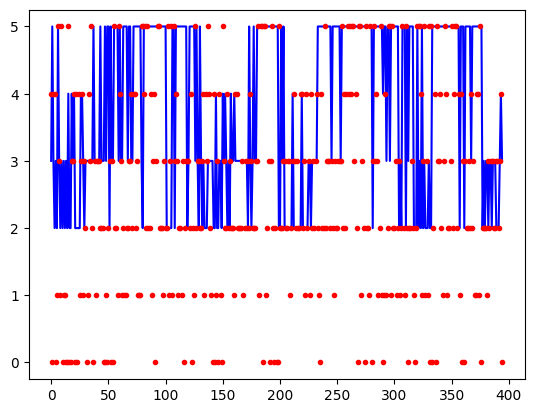

In [135]:
plt.plot(range(len(y_prediction)), y_prediction[:], "-b", label = f"Predicted")
plt.plot(range(len(y_prediction)), y_test[:], ".r", label = f"Actual")
plt.show()

In [62]:
y_pred = model.predict(x_test)
np.argmax(y_pred, axis=1)

13/13 [==============================] - 0s 5ms/step


array([1, 3, 3, 2, 3, 3, 3, 3, 0, 2, 3, 3, 2, 3, 2, 4, 3, 3, 3, 3, 4, 2,
       3, 0, 4, 3, 4, 2, 1, 4, 0, 1, 4, 2, 3, 4, 4, 1, 0, 4, 1, 2, 3, 4,
       4, 4, 2, 1, 4, 4, 4, 4, 4, 4, 4, 4, 4, 3, 3, 4, 4, 1, 1, 4, 0, 4,
       4, 4, 4, 2, 3, 3, 1, 1, 4, 5, 4, 1, 3, 4, 3, 4, 0, 4, 4, 3, 4, 4,
       0, 0, 0, 0, 0, 3, 0, 0, 3, 2, 5, 4, 5, 5, 5, 5, 5, 2, 3, 5, 5, 3,
       0, 3, 5, 5, 5, 3, 3, 5, 4, 3, 3, 2, 3, 4, 3, 0, 0, 3, 3, 2, 4, 0,
       3, 2, 3, 1, 2, 3, 2, 4, 3, 3, 5, 3, 3, 3, 4, 1, 3, 2, 3, 4, 3, 2,
       0, 3, 0, 3, 0, 4, 4, 1, 4, 2, 3, 1, 4, 4, 3, 0, 1, 4, 3, 3, 0, 1,
       2, 4, 4, 2, 3, 4, 0, 3, 4, 3, 4, 4, 5, 0, 0, 4, 5, 3, 5, 5, 5, 5,
       5, 5, 3, 5, 5, 3, 5, 5, 3, 5, 1, 3, 1, 5, 2, 4, 4, 5, 2, 2, 2, 2,
       2, 3, 3, 3, 2, 3, 2, 2, 3, 3, 3, 3, 3, 2, 3, 3, 4, 3, 3, 5, 3, 3,
       4, 3, 4, 4, 3, 3, 3, 3, 3, 4, 4, 3, 3, 3, 3, 0, 1, 3, 4, 0, 4, 2,
       5, 5, 5, 5, 5, 1, 5, 1, 1, 0, 0, 5, 3, 5, 0, 4, 3, 1, 4, 5, 0, 5,
       5, 5, 5, 5, 0, 3, 2, 3, 3, 5, 3, 2, 5, 3, 5,

In [63]:
y_pred

array([[2.38490731e-01, 3.78112078e-01, 1.00715585e-01, 3.39867212e-02,
        9.74805132e-02, 1.51214361e-01],
       [6.28492888e-03, 1.77679081e-02, 2.00170889e-01, 4.97829139e-01,
        6.15101755e-02, 2.16436952e-01],
       [4.25837748e-03, 3.43581550e-02, 2.49114502e-02, 7.03143835e-01,
        2.11214513e-01, 2.21136715e-02],
       ...,
       [9.45034903e-04, 4.56562615e-04, 2.12814718e-01, 7.76334941e-01,
        8.86903610e-03, 5.79698011e-04],
       [3.74155343e-01, 1.36052007e-02, 3.57971974e-02, 5.10003805e-01,
        2.86627375e-02, 3.77756506e-02],
       [8.79640758e-01, 1.38208456e-02, 5.39447181e-02, 6.12752000e-03,
        1.35553989e-03, 4.51105423e-02]], dtype=float32)

In [64]:
y_test

<tf.Tensor: shape=(395,), dtype=int32, numpy=
array([4, 0, 4, 4, 0, 1, 5, 3, 1, 5, 0, 1, 1, 0, 0, 5, 0, 0, 3, 3, 4, 0,
       4, 0, 4, 1, 3, 4, 1, 3, 2, 0, 1, 4, 3, 5, 2, 0, 3, 1, 3, 3, 3, 2,
       2, 2, 0, 0, 1, 0, 2, 3, 0, 3, 0, 5, 2, 2, 1, 5, 4, 3, 1, 2, 1, 1,
       2, 2, 3, 3, 4, 2, 4, 4, 2, 3, 1, 1, 1, 5, 5, 4, 5, 2, 5, 2, 2, 4,
       1, 3, 4, 0, 3, 5, 5, 2, 2, 2, 1, 3, 2, 2, 5, 1, 3, 5, 1, 5, 3, 4,
       3, 1, 2, 2, 1, 3, 0, 2, 3, 3, 3, 2, 4, 0, 2, 1, 5, 2, 3, 3, 2, 2,
       3, 4, 1, 4, 3, 5, 4, 2, 1, 0, 4, 0, 1, 3, 0, 4, 1, 0, 5, 3, 2, 2,
       4, 2, 3, 2, 2, 2, 1, 4, 4, 2, 2, 2, 2, 3, 1, 2, 3, 2, 3, 2, 4, 3,
       2, 2, 2, 3, 3, 5, 1, 5, 5, 0, 5, 5, 1, 2, 3, 0, 3, 5, 2, 0, 2, 0,
       0, 5, 2, 2, 2, 3, 3, 2, 2, 3, 3, 1, 2, 3, 4, 3, 2, 3, 2, 2, 4, 4,
       2, 3, 1, 4, 2, 3, 1, 4, 2, 3, 2, 3, 4, 2, 1, 0, 4, 2, 2, 5, 2, 3,
       3, 3, 2, 3, 2, 1, 3, 2, 2, 3, 3, 3, 5, 2, 4, 2, 4, 5, 4, 5, 4, 5,
       5, 3, 4, 2, 0, 5, 5, 1, 3, 2, 0, 5, 2, 2, 1, 5, 0, 3, 5, 3, 4, 3,
     

# LSTM Regression

In [5]:
NUMBER_OF_TRAINING_DATA = 10
EPOCHS = 50

TRAINING_PATH = "../data_collection/datasets/training"
TEST_PATH = "../data_collection/datasets/test"

x_training = np.load(os.path.join(TRAINING_PATH, "reg", "features.npy"), allow_pickle=True)
x_training = np.array([x_training[i].T for i in range(x_training.shape[0])])[-900:]
y_training = np.load(os.path.join(TRAINING_PATH, "reg", "labels.npy"), allow_pickle=True)[-900:]


INPUT_DIM = x_training.shape[1:]

x_training = tf.convert_to_tensor(x_training.astype('float32'))
y_training = tf.convert_to_tensor(y_training.astype('float32'))

# x_training = x_training.astype('float32')
# y_training = y_training.astype('int32')
# y_training = tf.one_hot(y_training, 5)



Metal device set to: Apple M2

systemMemory: 8.00 GB
maxCacheSize: 2.67 GB



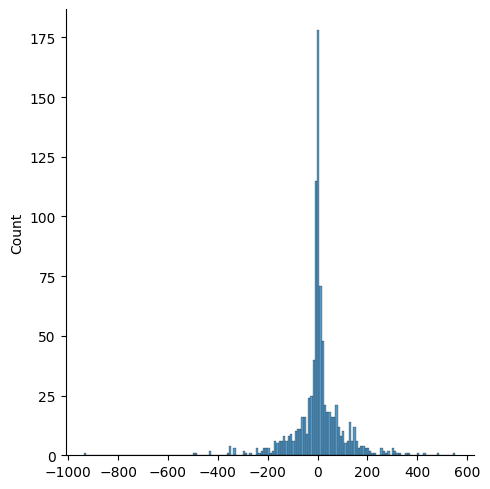

In [627]:
import seaborn as sns

sns.displot(y_training)

In [24]:
def create_lstm_regression_model(input_shape:Tuple[int, int]) -> tf.keras.Model:
    """Creates a regression model with LSTM layers."""
    model = tf.keras.Sequential([
        tf.keras.layers.InputLayer(input_shape=input_shape),
        tf.keras.layers.LSTM(64, activation="tanh", dropout=0.1, return_sequences=True),
        tf.keras.layers.LSTM(86, activation="tanh", return_sequences=True),
        tf.keras.layers.LSTM(128, activation="tanh"),
        # tf.keras.layers.Dense(128, activation="relu"),
        # tf.keras.layers.Dense(64, activation="relu"),
        tf.keras.layers.Dense(1)
    ])

    model.compile(
        # loss=weightedLoss(class_weights),
        loss=tf.keras.losses.MeanSquaredLogarithmicError(),
        optimizer=tf.keras.optimizers.legacy.Adam(learning_rate=0.005, epsilon=3e-03),
        metrics=["mae"]
    )

    return model

In [25]:
model = create_lstm_regression_model(INPUT_DIM)

In [26]:
history = model.fit(x_training, y_training, validation_split=0.10, epochs=EPOCHS, batch_size=64)

Epoch 1/50
13/13 [==============================] - 3s 86ms/step - loss: 4.6573 - mae: 57.5814 - val_loss: 4.5890 - val_mae: 79.9487
Epoch 2/50
13/13 [==============================] - 0s 25ms/step - loss: 3.6192 - mae: 57.9958 - val_loss: 4.6174 - val_mae: 79.9592
Epoch 3/50
13/13 [==============================] - 0s 22ms/step - loss: 3.5529 - mae: 57.7815 - val_loss: 4.7853 - val_mae: 80.0045
Epoch 4/50
13/13 [==============================] - 0s 23ms/step - loss: 3.5812 - mae: 57.6759 - val_loss: 4.7585 - val_mae: 80.0001
Epoch 5/50
13/13 [==============================] - 0s 23ms/step - loss: 3.5509 - mae: 57.7370 - val_loss: 4.7354 - val_mae: 79.9982
Epoch 6/50
13/13 [==============================] - 0s 22ms/step - loss: 3.5420 - mae: 57.7283 - val_loss: 4.7485 - val_mae: 80.0071
Epoch 7/50
13/13 [==============================] - 0s 21ms/step - loss: 3.5301 - mae: 57.7166 - val_loss: 4.7772 - val_mae: 80.0177
Epoch 8/50
13/13 [==============================] - 0s 22ms/step - lo

In [27]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_6 (LSTM)               (None, 23, 64)            25856     
                                                                 
 lstm_7 (LSTM)               (None, 23, 86)            51944     
                                                                 
 lstm_8 (LSTM)               (None, 128)               110080    
                                                                 
 dense_2 (Dense)             (None, 1)                 129       
                                                                 
Total params: 188,009
Trainable params: 188,009
Non-trainable params: 0
_________________________________________________________________


In [28]:
accuracy = history.history["mae"]
val_accuracy = history.history["val_acc"]

loss = history.history["loss"]
val_loss = history.history["val_loss"]

KeyError: 'val_acc'

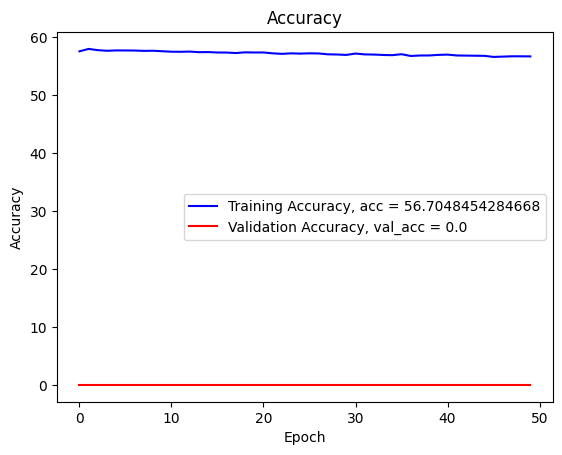

In [29]:
import matplotlib.pyplot as plt
plt.plot(range(len(accuracy)), accuracy, "b", label = f"Training Accuracy, acc = {accuracy[-1]}")
plt.plot(range(len(accuracy)), val_accuracy, "-r", label = f"Validation Accuracy, val_acc = {val_accuracy[-1]}")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.title("Accuracy")
plt.show()

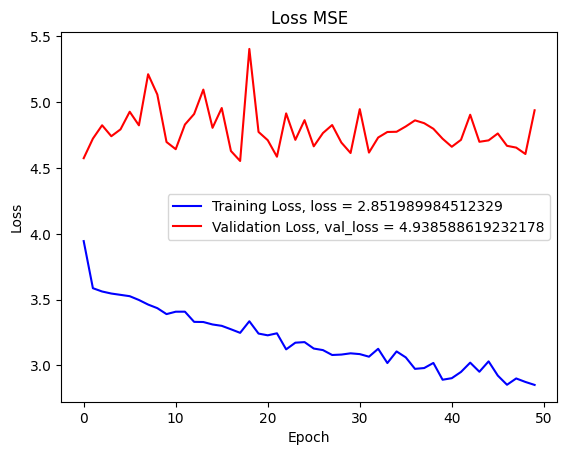

In [30]:
plt.plot(range(EPOCHS), loss, "b", label = f"Training Loss, loss = {loss[-1]}")
plt.plot(range(EPOCHS), val_loss, "-r", label = f"Validation Loss, val_loss = {val_loss[-1]}")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.title("Loss MSE")
plt.show()

In [31]:
x_test = np.load(os.path.join(TEST_PATH, "reg", "features.npy"), allow_pickle=True)
x_test = np.array([x_test[i].T for i in range(x_test.shape[0])])
y_test = np.load(os.path.join(TEST_PATH, "reg", "labels.npy"), allow_pickle=True)

INPUT_DIM = x_test.shape[1:]

x_test = tf.convert_to_tensor(x_test.astype('float32'))
y_test = tf.convert_to_tensor(y_test.astype('float32'))
# y_test = tf.one_hot(y_test, 5)

In [32]:
model.evaluate(x_test, y_test)

13/13 [==============================] - 0s 12ms/step - loss: 3.9227 - mae: 47.5587


[3.922714948654175, 47.5587043762207]